# **Black-Litterman Portfolio Optimization**
FRE 6083: Quantitative Methods in Finance

Professor Daniel Totouom-Tangho

Done by Harry Syllantavos and Sasha Agapiev

*For our final project, we will be implementing the Black-Litterman approach to portfolio optimization in Python. The Black-Litterman (B-L) model improves upon the Markowitz Mean-Variance model (MPT) by allowing investors to incorporate their subjective views about future asset returns.*

**Part 0: Importing Relevant Packages**

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from matplotlib import cm
from matplotlib.colors import ListedColormap
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import accuracy_score, precision_score, roc_auc_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import cross_val_predict
from numpy.linalg import inv

**Part 1: Calculating Expected Returns**

*We will be applying the B-L model to the XLG, which is a market-cap weighted exchange-traded fund of the 50 largest companies in the S&P 500. To do this, we start by finding the Implied Excess Return Equillibrium of XLG using the formula (1) from Idzorek's paper:*



$\Pi = λ∑w_{mkt}$              

Where:


*   $\Pi$ is the Implied Excess Return Equillibrium Vector (50x1 column vector)
*   $\lambda$ is the risk-aversion coefficient
*   $\sum$ is the covariance matrix of excess returns (50x50 matrix)
*   $w_{mkt}$ is the market capitalization weight (50x1 column vector) of the portfolio assets



In [ ]:
# Creating Pandas Dataframes from historical XLG asset returns and market cap weights
Portfolio_asset_returns = pd.read_excel('XLG Portfolio Returns.xlsx', index_col='Date', parse_dates=True)
Portfolio_asset_market_weights = pd.read_excel('XLG Portfolio Weights.xlsx', index_col='Asset')

In [ ]:
# Extract the risk-free rate from the dataframe
riskfree_rate1 = Portfolio_asset_returns['T-Bill']/12
riskfree_rate_historical = riskfree_rate1[:93]
riskfree_rate_realized = riskfree_rate1[93:]

In [ ]:
# Remove extraneous data from the csv files so we can apply matrix multiplications
asset_returns = Portfolio_asset_returns.iloc[:93, 2:]         # These are the historical returns we will use to calculate the B-L weights
realized_returns = Portfolio_asset_returns.iloc[93:, 2:]    # These are the realized returns (December 2021 - Current)
asset_weights = Portfolio_asset_market_weights.iloc[:, :]
# Make sure all data entries are converted to float64 type
asset_returns = asset_returns.apply(pd.to_numeric)
realized_returns = realized_returns.apply(pd.to_numeric)
asset_weights = asset_weights.apply(pd.to_numeric)

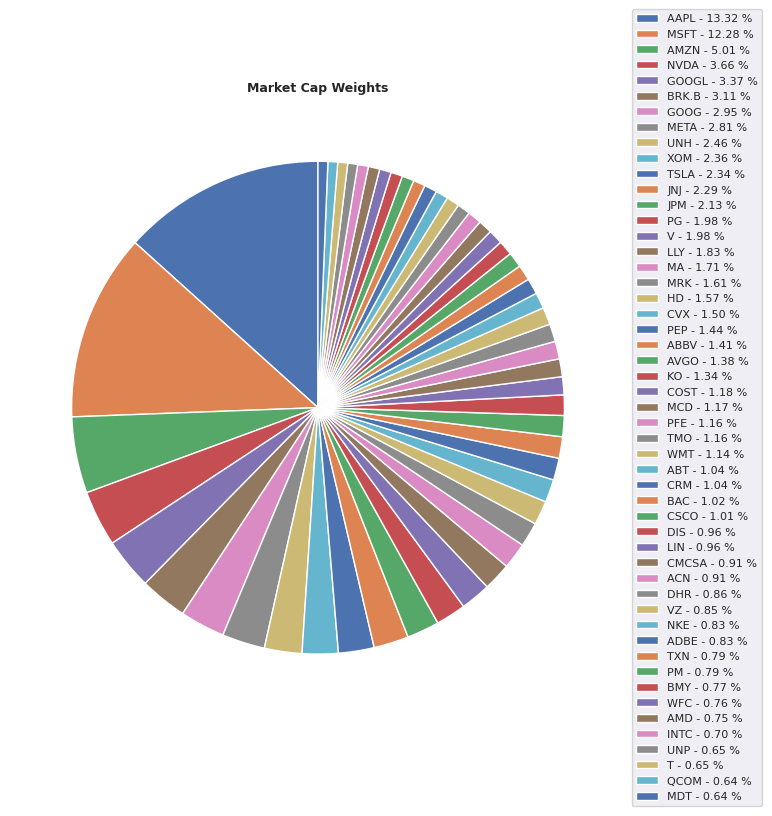

In [ ]:
# Let's visualize the market-cap weights of the XLG portfolio
cols = asset_returns.columns.values.tolist()
plt.figure(figsize=(8,8))
x = cols
y = asset_weights.values.flatten()
porcent = 100.*y/y.sum()
patches, texts = plt.pie(y, startangle=90)
labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(x, porcent)]
sort_legend = True
if sort_legend:
    patches, labels, dummy =  zip(*sorted(zip(patches, labels, y),
                                          key=lambda x: x[2],
                                          reverse=True))
plt.legend(patches, labels, loc='center left', bbox_to_anchor=(1, 0.5),
           fontsize=8)
plt.title("Market Cap Weights", weight="bold")
plt.show()

In [ ]:
# Excess returns are defined as XLG historical returns minus the rf rate
excess_asset_returns = asset_returns.subtract(riskfree_rate_historical, axis=0)
excess_asset_returns_realized = realized_returns.subtract(riskfree_rate_realized, axis=0)

# The covariance matrix is found using Python's built-in method
cov = excess_asset_returns.cov()
# The mean XLG return is defined as the mean excess return multiplied by asset market cap weights
XLG_return = excess_asset_returns.mean().multiply(asset_weights['Market Cap Weight'].values).sum()
# The mean XLG variance is defined as the transpose of market cap weights multiplied by the product of covariance and weights
XLG_variance = np.matmul(asset_weights.values.reshape(len(asset_weights)).T,
                                       np.matmul(cov.values, asset_weights.values.reshape(len(asset_weights))))
# We can use the mean market return and variance to find the risk aversion parameter (lambda)
lambda_coeff = XLG_return / XLG_variance

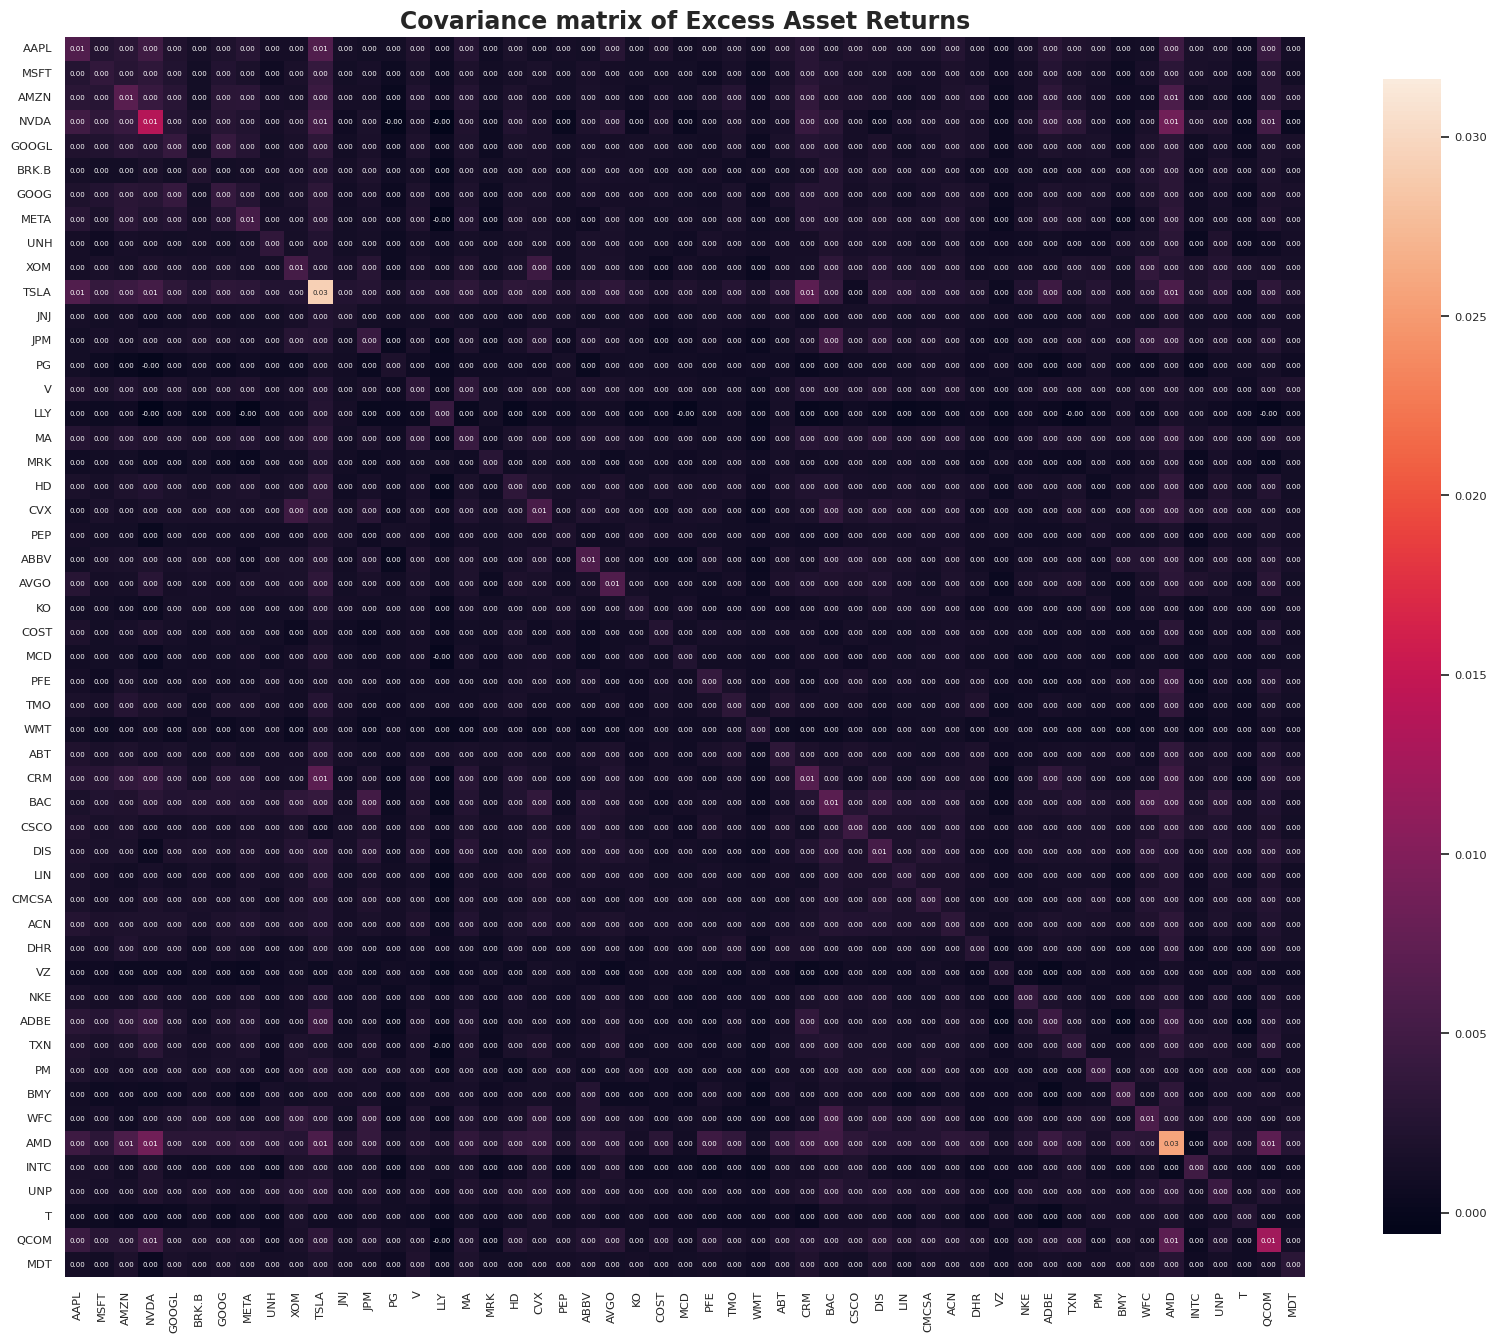

In [ ]:
# Plotting the covariance matrix for visualization purposes
plt.figure(figsize=(20,20))
sns.set(font_scale=0.75)
cols = asset_returns.columns.values.tolist()
hm = sns.heatmap(cov,
                 cbar=True,
                 annot=True,
                 square=True,
                 fmt='.2f',
                 vmin=-0.0006,
                 vmax=0.0316,
                 annot_kws={'size': 5},
                 cbar_kws={'shrink':0.75},
                 yticklabels=cols,
                 xticklabels=cols)
plt.title('Covariance matrix of Excess Asset Returns', weight='bold', fontsize=17)
plt.show()

In [ ]:
# Before continuing, we check our calculations to see if the values make logical sense
print('Mean XLG Return: ', str(XLG_return))
print('Mean XLG Variance: ', str(XLG_variance))
print('XLG Risk Aversion Parameter (lambda): ', str(lambda_coeff))

Mean XLG Return:  0.01974019277777778
Mean XLG Variance:  0.0018989189143758126
XLG Risk Aversion Parameter (lambda):  10.395490101412


In [ ]:
# We can now reverse-engineer the implied excess return equilibrium using Idzorek's formula (1)
implied_excess_returns = lambda_coeff * cov.dot(asset_weights.to_numpy())
implied_excess_returns.columns=['Implied Excess Return']
implied_excess_returns = implied_excess_returns.squeeze()

We have thus found $\Pi$:

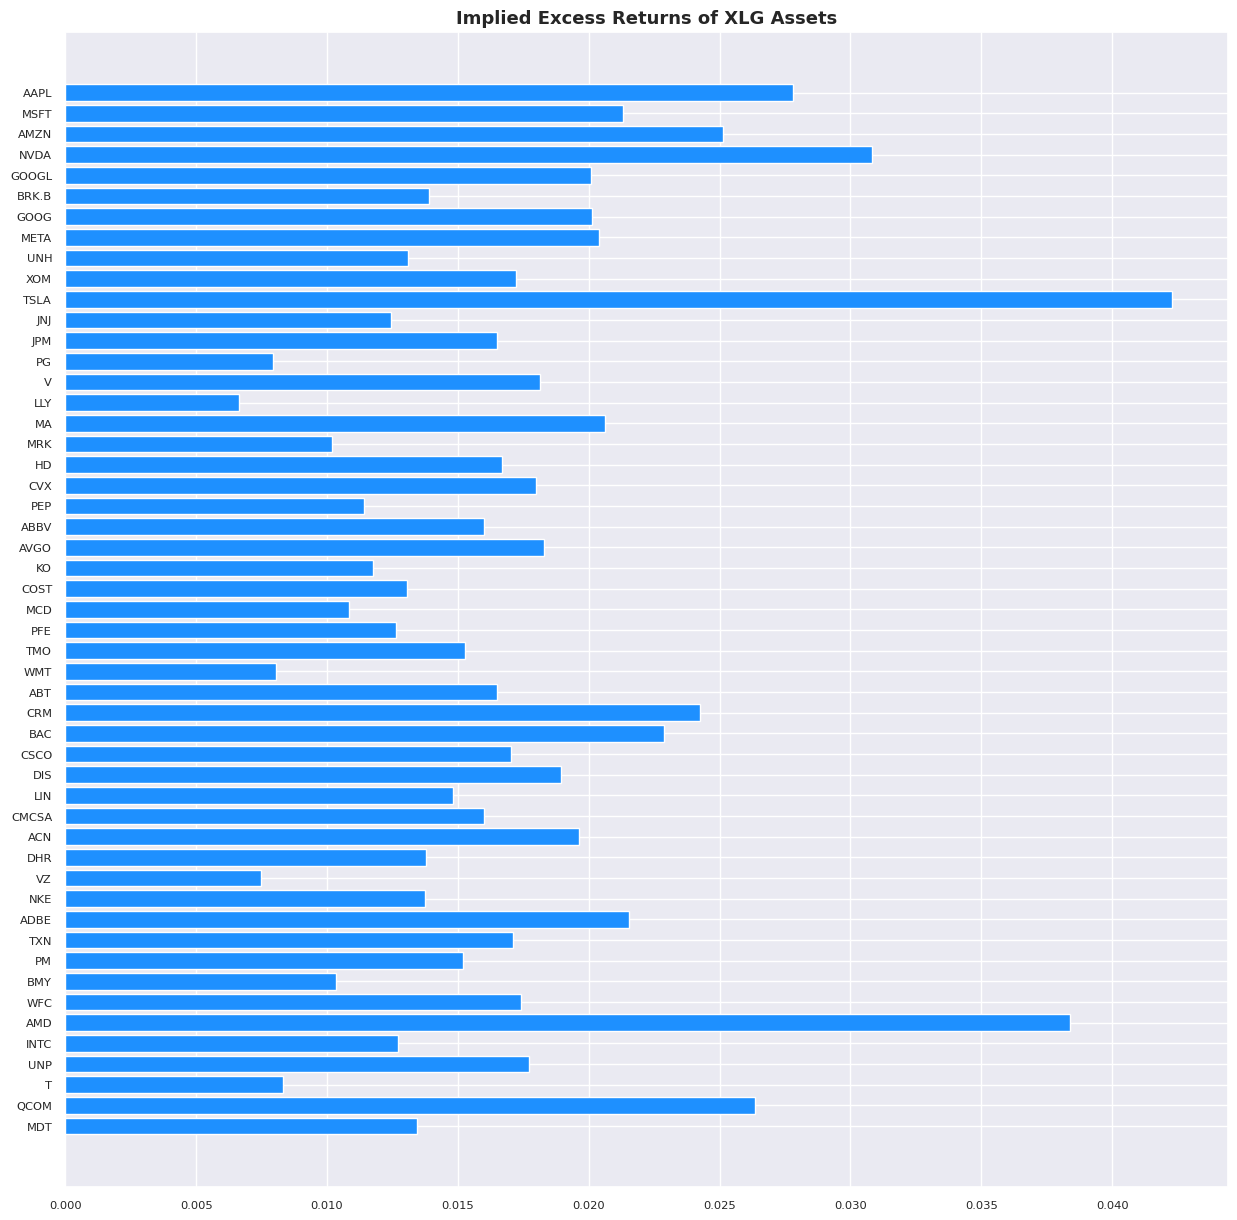

In [ ]:
plt.figure(figsize=(15, 15))
plt.barh(np.flip(cols), np.flip(implied_excess_returns), align='center', color='dodgerblue')
plt.title('Implied Excess Returns of XLG Assets', weight='bold', fontsize=13)
plt.show()

**Part 2: Asset View Forecasts Using ML**

*We will use a ML-powered momentum strategy to predict future monthly excess returns of various assets in the portfolio. To do this, we will train a K Nearest Neighbor (KNN) model with 3 neighbors on lagged monthly excess returns. The predictions generated by this momentum strategy will serve as our asset view forecasts (both absolute and relative) which will be incorporated into the B-L model in Part 3.*

In [ ]:
# Creating a lagged_excess_returns DataFrame by running a for loop for each
# asset and then adding 1-10 month lags using the Pandas shift() method
lagged_excess_returns = excess_asset_returns.copy()
for col in lagged_excess_returns.columns:
  for lag in range(1,13):           # Using 1-12 month lag
    lag_column_title = col + " " + str(lag) + " Month Lag"
    lagged_excess_returns[lag_column_title] = lagged_excess_returns[col].shift(periods=lag)

In [ ]:
# Checking if the return lags were added correctly
lagged_excess_returns

,AAPL,MSFT,AMZN,NVDA,GOOGL,BRK.B,GOOG,META,UNH,XOM,...,MDT 3 Month Lag,MDT 4 Month Lag,MDT 5 Month Lag,MDT 6 Month Lag,MDT 7 Month Lag,MDT 8 Month Lag,MDT 9 Month Lag,MDT 10 Month Lag,MDT 11 Month Lag,MDT 12 Month Lag
Date,,,,,,,,,,,,,,,,,,,,,
2014-04-01,0.099175,-0.014625,-0.095925,0.031075,-0.041325,0.030775,-0.054625,-0.007825,-0.085025,0.048175,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-05-01,0.072483,0.013183,0.027383,0.028483,0.068483,-0.004217,0.062983,0.058683,0.060983,-0.018617,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-06-01,0.027483,0.018383,0.038783,-0.024417,0.022583,-0.014117,0.027383,0.062783,0.026383,0.001283,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-07-01,0.028492,0.034792,-0.036508,-0.056308,-0.009008,-0.009108,-0.006808,0.079492,-0.008808,-0.017508,...,-0.044425,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-08-01,0.072000,0.052400,0.082900,0.111200,0.004600,0.094000,-0.000200,0.029700,0.069300,0.005100,...,0.037383,-0.044425,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-01,0.040792,0.059492,0.042892,0.147892,0.073892,0.026792,0.075592,0.064692,0.009692,-0.053108,...,-0.033233,0.108167,0.009767,0.050592,-0.049692,0.030225,0.130525,-0.032267,-0.033058,0.113842
2021-09-01,-0.068117,-0.066217,-0.053617,-0.074717,-0.076317,-0.045017,-0.083917,-0.105517,-0.061417,0.078783,...,-0.019525,-0.033233,0.108167,0.009767,0.050592,-0.049692,0.030225,0.130525,-0.032267,-0.033058
2021-10-01,0.058567,0.176167,0.026467,0.234067,0.107367,0.051367,0.112467,-0.046733,0.178367,0.095967,...,0.057692,-0.019525,-0.033233,0.108167,0.009767,0.050592,-0.049692,0.030225,0.130525,-0.032267


In [ ]:
 # ~
 # get_KNN_view() is a helper function which takes the following arguments:
 #            ticker: target asset ticker (string)
 #            print_summary: toggle summary printing (boolean)
 # The function returns:
 #            predicted_return: The asset's predicted excess return for the next month
 #            confidence_score: The r squared accuracy of the KNN model
 #
 # The function works by training a 3-neighbor KNN on historical lagged returns
 # and then making a prediction based on the past month of lagged
 # returns. The confidence score is found by taking the mean of 5-fold cross
 # validation.
 # ~
def get_KNN_view(ticker, print_summary=False):
  # The target vector (y_set) is the actual excess return, while
  # the data matrix (x_set) are the 1-12 month lagged returns
  y_set = lagged_excess_returns[ticker]
  X_set = lagged_excess_returns[[(str(ticker + " 1 Month Lag")), (str(ticker + " 2 Month Lag")),
                                 (str(ticker + " 3 Month Lag")), (str(ticker + " 4 Month Lag")),
                                 (str(ticker + " 5 Month Lag")), (str(ticker + " 6 Month Lag")),
                                 (str(ticker + " 7 Month Lag")), (str(ticker + " 8 Month Lag")),
                                 (str(ticker + " 9 Month Lag")), (str(ticker + " 10 Month Lag")),
                                 (str(ticker + " 11 Month Lag")), (str(ticker + " 12 Month Lag"))]]
  # We train the KNN on 8 years of lagged returns
  y_train = y_set[12:-1]
  X_train = X_set[12:-1]
  # We predict the next month of returns using the trained KNN
  X_predict = X_set[-1:]
  # Using y_train and x_train to train a KNN model with 3 neighbors
  KNN_model = KNeighborsRegressor(n_neighbors=3).fit(X_train, y_train)
  KNN_predicted_returns = KNN_model.predict(X_predict)
  predicted_return = round(KNN_predicted_returns[0], 4)
  confidence_score_unrounded = (cross_val_score(KNN_model, X_train, y_train, cv=5, scoring='r2').mean()) * -1
  confidence_score = round(confidence_score_unrounded, 4)
  if print_summary:
    print(ticker + ' is predicted to have an excess return of ' + str(predicted_return) + ' with an r squared confidence score of ' + str(confidence_score))
  else:
    return predicted_return, confidence_score

In [ ]:
# Let's test the KNN prediction function on Costco, Exxon, and United Health Group
get_KNN_view('COST', print_summary=True)
get_KNN_view('XOM', print_summary=True)
get_KNN_view('UNH', print_summary=True)

COST is predicted to have an excess return of -0.0446 with an r squared confidence score of 0.6387
XOM is predicted to have an excess return of -0.0221 with an r squared confidence score of 0.3492
UNH is predicted to have an excess return of 0.0232 with an r squared confidence score of 0.2854


*As we can see, the KNN model makes realistic predictions about monthly excess returns, but the confidence scores are typically low.*

*We can generate predictions for all 50 assets in XLG and reject those below a certain confidence threshold.*

In [ ]:
# Using the KNN to find views with confidence greater than 65%
confidence_threshold = 0.65
view_dict = {}
count = 0
for col in asset_returns.columns:
  prediction, confidence = get_KNN_view(col)
  if confidence > confidence_threshold:
    view_dict[col] = prediction
    count += 1

print("The KNN made " + str(count) + " predictions with over " + str(confidence_threshold * 100) + " % confidence.")
view_dict

The KNN made 12 predictions with over 65.0 % confidence.


{'AAPL': -0.0362,
 'ABBV': 0.001,
 'KO': -0.0102,
 'ABT': 0.0132,
 'BAC': -0.0437,
 'TXN': 0.0048,
 'PM': -0.0189,
 'BMY': 0.0099,
 'WFC': -0.0443,
 'UNP': 0.0403,
 'T': -0.0278,
 'QCOM': -0.0598}

*The KNN only predicts absolute views. We will use Bloomberg Terminal data to incorporate the five following relative views:*


*   AMZN will outperform AAPL by 1.8%
*   QCOM will outperform MDT by 2.2%
*   GOOG will outperform META by 0.3%
*   PFE will outperform WMT by 1.2%
*   DIS will outperform NKE by 1.4%

*We have now generated 17 views (K = 17) for our XLG portfolio.*


**Part 3: The Black-Litterman Model**

*Now that we have found the excess return equilibrium ($\Pi$) and have established asset views using KNN predictions and Bloomberg data, we can incorporate these views into our portfolio using the Black-Litterman formula:*

$E[R] = [(τ∑)^{-1} + P'Ω^{-1}P]^{-1} [(τ∑)^{-1}\Pi + P'Ω^{-1}Q]$

Where:


*   $E[R]$ is the new/posterior combined return vector (50x1 column vector)
*   $\tau$ is a scalar
*   $\sum$ is the covariance matrix of excess returns (50x50 matrix)
*   $P$ is a matrix that identifies the assets involved in the forecast views (17x50 matrix)
*   $Ω$ is a diagonal covariance matrix of error terms from the expressed views representing the uncertainty of each view (17x17 matrix)
*   $\Pi$ is the implied equillibrium return vector calculated in the previous part (50x1 column vector)
*   $Q$ is the forecast view vector (17x1 column vector)



In [ ]:
#Q is just the array of views (17x1 column vector)

#Keeping this in case we need it again
Q = np.array([-0.0362, 0.001, -0.0102, 0.0132, -0.0437, 0.0048, -0.0189, 0.0099, -0.0443, 0.0403, -0.0278, -0.0598, 0.018, 0.022, 0.003, 0.012, 0.014])

#Getting key value pairs in the dictionary
KNN_key_value_pairs = view_dict.items()

#converting all objects to a list
list_data = list(KNN_key_value_pairs)

#Converting list to NumPy array
KNN_views = np.array(list_data)

#Relative performance views as found on Bloomberg
bloomberg_relative_views = np.array([0.018, 0.022, 0.003, 0.012, 0.014])

#KNN_views.info()
bloomberg_relative_views

array([0.018, 0.022, 0.003, 0.012, 0.014])

*P is the matrix used to match views to their corresponding assets (e.g: Apple is the first asset, so we add a 1 to the first view row).*

*To avoid undesired tracking error, we use the Litterman method instead of the Satchell and Scowcroft method for building the P matrix.*


In [ ]:
# ~
# find_asset_position() is a helper function for finding an asset's position in P.
# The function takes the following argument:
#         ticker: The ticker of the target asset (string)
# The function returns:
#         count: The 0-indexed position of the asset in P (int)
# ~
def find_asset_position(ticker):
  count = 0
  found = False
  for t in asset_returns.columns:
    if t == ticker:
      return count
    else:
      count += 1


# ~
# litterman_method() is a helper function that assigns relative view weights to two assets based on their market cap weights.
# The function takes the following arguments:
#         ticker1: The ticker of the first asset (string)
#         ticker2: The ticker of the second asset (string)
# The function returns:
#         weight1: The weight proportion of the first asset (float64)
#         weight2: The weight proportion of the second asset (float64)
# ~
def litterman_method(ticker1, ticker2):
  pos1 = find_asset_position(ticker1)
  pos2 = find_asset_position(ticker2)
  mkt_weight1 = asset_weights.iloc[pos1][0]
  mkt_weight2 = asset_weights.iloc[pos2][0]
  total_weight = mkt_weight1 + mkt_weight2
  weight1 = mkt_weight1 / total_weight
  weight2 = mkt_weight2 / total_weight
  return weight1, weight2

In [ ]:
P = np.zeros((17, 51))

for i in range(len(KNN_views)):
  P[i][find_asset_position(KNN_views[i][0])] = 1

rindx = len(KNN_views)
P[rindx][find_asset_position('AMZN')] = 1
P[rindx][find_asset_position('AAPL')] = -1
P[rindx+1][find_asset_position('QCOM')] = 1
P[rindx+1][find_asset_position('MDT')] = -1
P[rindx+2][find_asset_position('GOOG')] = 1
P[rindx+2][find_asset_position('META')] = -1
P[rindx+3][find_asset_position('PFE')] = 1
P[rindx+3][find_asset_position('WMT')] = -1
P[rindx+4][find_asset_position('DIS')] = 1
P[rindx+4][find_asset_position('NKE')] = -1

In [ ]:
# According to Idzorek, the tau scalar and omega matrix are both subjectively estimated
# Various economists have used different tau values in their B-L implementations
# Since the uncertainty in the mean is less than the return uncertainty, tau is typically set between 0.01 and 0.05
# We will set tau = (0.05 + 0.01) / 2 = 0.03 for now, but we can experiment with different values later
tau = 0.03

*Now that we have quantified the asset views and have established a τ scalar, we can calculate the variance of the individual view portfolios using the following formula:*

$p_{k}∑p_{k}^{'}$

Where:


*   $p_{k}$ is a single 1xN row vector from P that corresponds to the kth view
*   $∑$ is the covariance matrix of excess returns

*These individual view portfolio variances act as the diagonal values in the Ω matrix.*

In [ ]:
# Omega is defined as the diagonal matrix of tau * variance of individual view portfolios
omega = np.diag(np.diag(P.dot(tau * cov).dot(P.T)))

In [ ]:
# We now have all the elements necessary for calculating the new/posterior combined return vector
tau_cov = tau * cov
tau_cov_inv = inv(tau_cov)
pp_1 = np.matmul((P.T), (inv(omega)))
pp = np.matmul(pp_1, P)
pq_1 = np.matmul((P.T), (inv(omega)))
pq = np.matmul(pq_1, Q)
one_1 = np.add(tau_cov_inv, pp)
one = inv(one_1)
two = np.add((np.matmul(tau_cov_inv, implied_excess_returns)), pq)
posterior_return_vector = one.dot(two)

In [ ]:
# Finally, we can calculate the Black-Litterman portfolio weights by solving the unconstrained maximization problem
inverse_covariance = pd.DataFrame(inv(cov.values), index=cov.columns, columns=cov.index)
BL_weights = inverse_covariance.dot(posterior_return_vector)
BL_weights = BL_weights / sum(BL_weights)

*Now that we have established the Black-Litterman returns and weights, let's visualize how the B-L portfolio differs from the XLG portfolio:*

In [ ]:
# The results are numpy arrays, but they would be easier to read as Dataframes
BL_Returns = pd.DataFrame(data=posterior_return_vector,
                          index=cols,
                          columns=["B-L Return"])

BL_Weights = pd.DataFrame(data=BL_weights,
                          index=cols,
                          columns=["B-L Weight"])
implied_returns_df = pd.DataFrame(data=implied_excess_returns,
                                  index=cols)

In [ ]:
# We will create a summary table to show all the results
BL_vs_Implied_Returns = pd.concat([implied_returns_df, BL_Returns], axis=1)
BL_vs_Implied_Returns["Return Difference"] = BL_vs_Implied_Returns["B-L Return"] - BL_vs_Implied_Returns["Implied Excess Return"]
BL_vs_Market_Weights = pd.concat([asset_weights, BL_Weights], axis=1)
BL_vs_Market_Weights *= 100
Summary_Table1 = pd.concat([BL_vs_Implied_Returns, BL_vs_Market_Weights], axis=1)
Summary_Table1["Weight Difference"] = Summary_Table1['B-L Weight'] - Summary_Table1['Market Cap Weight']
Summary_Table = Summary_Table1.style.format('{:,.3f}%')
Summary_Table

,Implied Excess Return,B-L Return,Return Difference,Market Cap Weight,B-L Weight,Weight Difference
AAPL,0.028%,-0.009%,-0.037%,13.320%,100.268%,86.948%
MSFT,0.021%,-0.001%,-0.022%,12.280%,-41.298%,-53.578%
AMZN,0.025%,0.007%,-0.018%,5.010%,-23.148%,-28.158%
NVDA,0.031%,-0.004%,-0.034%,3.660%,-12.309%,-15.969%
GOOGL,0.020%,-0.002%,-0.022%,3.370%,-11.333%,-14.703%
BRK.B,0.014%,-0.006%,-0.020%,3.110%,-10.459%,-13.569%
GOOG,0.020%,-0.002%,-0.022%,2.950%,-5.331%,-8.281%
META,0.020%,-0.005%,-0.026%,2.810%,-14.040%,-16.850%
UNH,0.013%,0.005%,-0.008%,2.460%,-8.273%,-10.733%
XOM,0.017%,-0.007%,-0.025%,2.360%,-7.937%,-10.297%


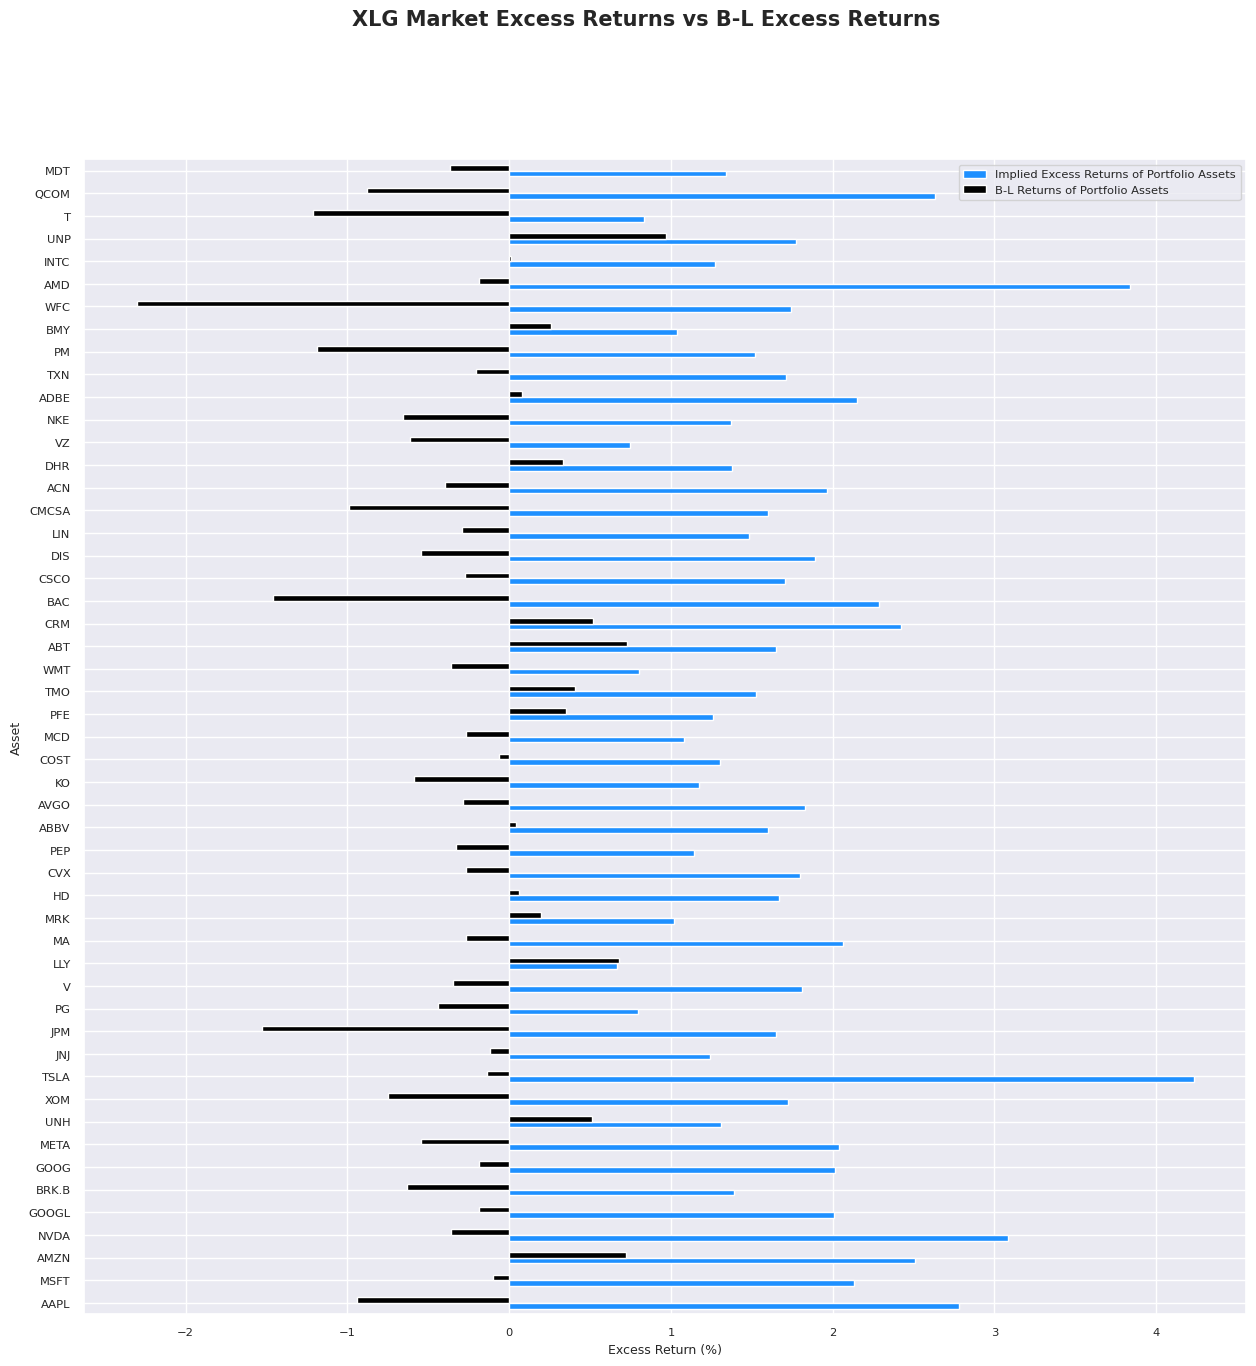

In [ ]:
import pylab as pl
plt.rcParams["figure.figsize"] = (15,15)
matplotlib.rcParams.update({'font.size': 25})
MCR = implied_excess_returns.values.flatten() * 100
BLR = posterior_return_vector * 100
plot_df = pd.DataFrame({'Implied Excess Returns of Portfolio Assets': MCR, 'B-L Returns of Portfolio Assets':BLR}, index=cols)
mycmp = ListedColormap(['dodgerblue', 'black'])
axes = plot_df.plot.barh(xlabel='Excess Return (%)', ylabel='Asset', colormap=mycmp)
pl.suptitle("XLG Market Excess Returns vs B-L Excess Returns", fontsize=15, fontweight='bold')
pl.show()

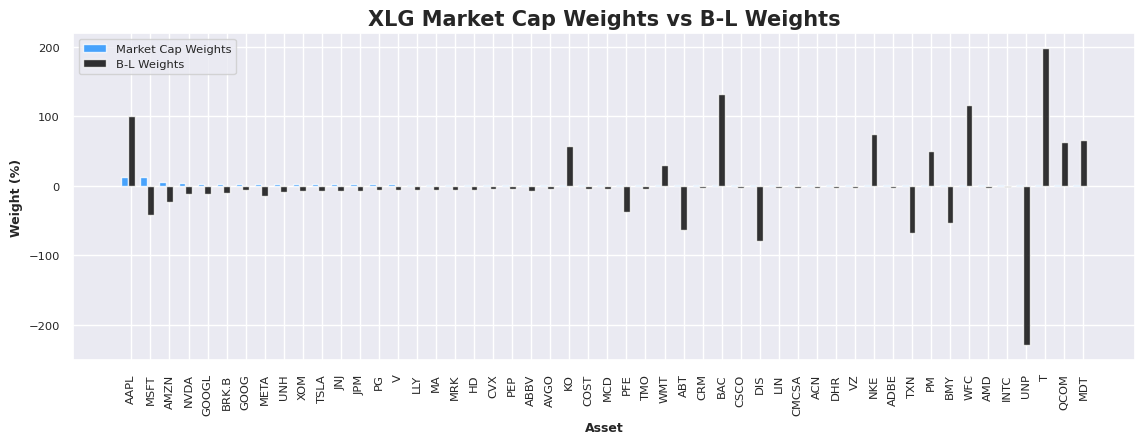

In [ ]:
# Plotting bar charts of portfolio weights
plt.rcParams["figure.figsize"] = (12,5)
fig, ax = plt.subplots()
n_groups = 51
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8
MC = asset_weights.values.flatten() * 100
BL = BL_weights.values * 100
rects1 = plt.bar(index, MC, bar_width, alpha=opacity, color='dodgerblue', label='Market Cap Weights')
rects2 = plt.bar(index + bar_width, BL, bar_width, alpha=opacity, color='black', label='B-L Weights')
plt.xlabel('Asset', weight='bold')
plt.ylabel('Weight (%)', weight='bold')
plt.title('XLG Market Cap Weights vs B-L Weights', weight='bold', fontsize=15)
plt.xticks(index + bar_width, cols)
plt.legend()
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
# Quantifying which assets are most overweight and underweight in the B-L portfolio
over_vs_under = Summary_Table1.sort_values('Weight Difference', ascending=False)
over = over_vs_under['Weight Difference'][:5].index.values
under = np.flip(over_vs_under['Weight Difference'][-5:].index.values)
print("The 5 most overweight stocks in the B-L portfolio are: ")
print(over)
print("The 5 most underweight stocks in the B-L portfolio are: ")
print(under)

The 5 most overweight stocks in the B-L portfolio are: 
['T' 'BAC' 'WFC' 'AAPL' 'NKE']
The 5 most underweight stocks in the B-L portfolio are: 
['UNP' 'DIS' 'TXN' 'ABT' 'BMY']


*As we can see, the assets with no associated forecast views experienced minimal weight change. This validates our Black-Litterman implementation since the B-L model is supposed to incorporate views for specific assets without strongly influencing the other asset weights in the portfolio.*

**Part 4: Comparing Portfolio Performance**




*In this section, having calculated the portfolio weights for the XLG portfolio using the Black-Litterman model, we will compare the performance of the Black-Litterman potfolio with that of the market capitalization-weighted portfolio for the period 1/1/2022 - 5/1/2023.*

*This performance comparison can be thought of as a portfolio backtest on the past 17 months of trading data.*

In [ ]:
# The calculations for these performance metrics are taken from Notes 7 and 12 in Idzorek's paper
# We round each calculation to 4 digits for viewing simplicity
#
# It is also important to note that we multiply the realized returns by 17 to account for the
# fact that our historical excess return data is monthly, and the backtest accounts for 17
# months of excess returns
XLG_realized_return = (excess_asset_returns_realized.mean().multiply(asset_weights['Market Cap Weight'].values).sum()) * 17
BL_realized_return = (excess_asset_returns_realized.mean().multiply(BL_weights.values).sum()) * 17
XLG_realized_return = round((XLG_realized_return * 100), 4)
BL_realized_return = round((BL_realized_return * 100), 4)
XLG_portfolio_variance = round(XLG_variance, 4)
BL_portfolio_variance = np.matmul(BL_Weights.values.reshape(len(BL_Weights)).T,
                        np.matmul(cov.values, BL_weights.values.reshape(len(BL_Weights))))
BL_portfolio_variance = round(BL_portfolio_variance, 4)
XLG_portfolio_stdev = np.sqrt(XLG_portfolio_variance)
XLG_portfolio_stdev = round(XLG_portfolio_stdev, 4) * 100
BL_portfolio_stdev = np.sqrt(BL_portfolio_variance)
BL_portfolio_stdev = round(BL_portfolio_stdev, 4) * 100
XLG_portfolio_beta = 1   # By definition
BL_portfolio_beta = np.dot(((cov.dot(asset_weights.to_numpy())) / BL_portfolio_variance).T, BL_weights)
BL_portfolio_beta = round(BL_portfolio_beta[0], 4)
XLG_portfolio_sharpe = XLG_realized_return / XLG_portfolio_stdev
XLG_portfolio_sharpe = round(XLG_portfolio_sharpe, 4)
BL_portfolio_sharpe = BL_realized_return / BL_portfolio_stdev
BL_portfolio_sharpe = round(BL_portfolio_sharpe, 4)
BL_residual_return = BL_realized_return - (BL_portfolio_beta * BL_realized_return)
BL_residual_return = round(BL_residual_return, 4)
rrsquared = BL_portfolio_variance - (np.square(BL_portfolio_beta) * XLG_portfolio_variance)
BL_residual_risk = np.sqrt(rrsquared)
BL_residual_risk = round(BL_residual_risk, 4)
BL_active_return = BL_realized_return - XLG_realized_return
BL_active_return = round(BL_active_return, 4)
BL_active_portfolio_beta = BL_portfolio_beta - XLG_portfolio_beta
BL_active_portfolio_beta = round(BL_active_portfolio_beta, 4)
arsquared = np.square(BL_residual_risk) + (np.square(BL_active_portfolio_beta) * XLG_portfolio_variance)
BL_active_risk = np.sqrt(arsquared)
BL_active_risk = round(BL_active_risk, 4)

In [ ]:
from prettytable import PrettyTable
analysis_table = PrettyTable([" ", "XLG (Benchmark) Portfolio", "B-L Portfolio"])
analysis_table.add_row(["Excess Return", str(XLG_realized_return) + '%' , str(BL_realized_return) + '%'])
analysis_table.add_row(["Variance", XLG_portfolio_variance, BL_portfolio_variance])
analysis_table.add_row(["Standard Deviation", str(XLG_portfolio_stdev) + '%', str(BL_portfolio_stdev) + '%'])
analysis_table.add_row(["Beta", XLG_portfolio_beta, BL_portfolio_beta])
analysis_table.add_row(["Residual Return", '-', str(BL_residual_return) + '%'])
analysis_table.add_row(["Residual Risk", '-', str(BL_residual_risk) + '%'])
analysis_table.add_row(["Active Return", '-', str(BL_active_return) + '%'])
analysis_table.add_row(["Active Risk", '-', str(BL_active_risk) + '%'])
analysis_table.add_row(["Sharpe Ratio", XLG_portfolio_sharpe, BL_portfolio_sharpe])
print(analysis_table)

+--------------------+---------------------------+---------------+
|                    | XLG (Benchmark) Portfolio | B-L Portfolio |
+--------------------+---------------------------+---------------+
|   Excess Return    |          -3.3332%         |    -4.1103%   |
|      Variance      |           0.0019          |      0.04     |
| Standard Deviation |           4.36%           |     20.0%     |
|        Beta        |             1             |     0.0241    |
|  Residual Return   |             -             |    -4.0112%   |
|   Residual Risk    |             -             |      0.2%     |
|   Active Return    |             -             |    -0.7771%   |
|    Active Risk     |             -             |    0.2045%    |
|    Sharpe Ratio    |          -0.7645          |    -0.2055    |
+--------------------+---------------------------+---------------+
